## Reproducing Original Demo
We followed the original demo in the Mazzoni paper and we should see similar output to the original demo. However, The original demo does not have current, so we need to generate that on our own. 
This is how we followed the orogimal code:


In [1]:
import brian2.only as b2
import numpy as np
import matplotlib.pyplot as plt

## Alpha post-synaptic currents

INFO       The synaptic equation for the variable I_syn_syn does not specify whether it should be integrated at every timestep ('clock-driven') or only at spiking events ('event-driven'). It will be integrated at every timestep which can slow down your simulation unnecessarily if you only need the values of this variable whenever a spike occurs. Specify the equation as clock-driven explicitly to avoid this warning. [brian2.synapses.synapses.clock_driven]
INFO       The synaptic equation for the variable s does not specify whether it should be integrated at every timestep ('clock-driven') or only at spiking events ('event-driven'). It will be integrated at every timestep which can slow down your simulation unnecessarily if you only need the values of this variable whenever a spike occurs. Specify the equation as clock-driven explicitly to avoid this warning. [brian2.synapses.synapses.clock_driven]


INFO       No numerical integration method specified for group 'neurongroup', using method 'exact' (took 0.23s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses', using method 'euler' (took 0.01s, trying other methods took 0.01s). [brian2.stateupdaters.base.method_choice]


1.077114452572003
1.077114452572003
1.077114452572003


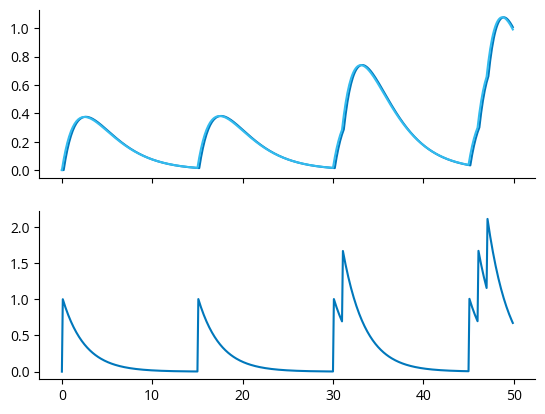

In [2]:
b2.prefs.codegen.target = "numpy"
ng = b2.NeuronGroup(
    1,
    """dv/dt = (I_syn - v)/ms : 1
    I_syn : 1""",
)
t_spk = [0, 15, 30, 31, 45, 46, 47] * b2.ms
sgg = b2.SpikeGeneratorGroup(
    1,
    np.zeros(len(t_spk)),
    t_spk,
)
# alpha current synapse
tau_syn = 2.5 * b2.ms
syn = b2.Synapses(
    sgg,
    ng,
    """dI_syn_syn/dt = (s - I_syn)/tau_syn : 1
    I_syn_post = I_syn_syn : 1 (summed)
    ds/dt = -s/tau_syn : 1""",
    on_pre="s += 1",
)
syn.connect(i=0, j=0)
syn_mon = b2.StateMonitor(syn, ["I_syn", "s"], record=True)
net = b2.Network(ng, sgg, syn, syn_mon)
net.run(50 * b2.ms)
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(syn_mon.t / b2.ms, syn_mon.I_syn[0])
print(syn_mon.I_syn.max())

# t_conv = np.linspace(0, syn_mon.t[-1], len(syn_mon.t))
t_conv = np.array(syn_mon.t) * b2.second
t_spk_conv = t_conv[..., None] - t_spk
I_syn_conv = t_spk_conv / tau_syn * np.exp(1 - t_spk_conv / tau_syn) * (t_spk_conv >= 0)
print(syn_mon.I_syn.max())
I_syn_conv = I_syn_conv.sum(axis=1)
I_syn_conv = I_syn_conv / I_syn_conv.max() * syn_mon.I_syn[0].max()
print(I_syn_conv.max())
ax1.plot(syn_mon.t / b2.ms, I_syn_conv)

ax2.plot(syn_mon.t / b2.ms, syn_mon.s[0])

## Biexpoenential synaptic currents

INFO       No numerical integration method specified for group 'neurongroup_1', using method 'exact' (took 0.00s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_1', using method 'euler' (took 0.01s, trying other methods took 0.01s). [brian2.stateupdaters.base.method_choice]


0.3158446318076699


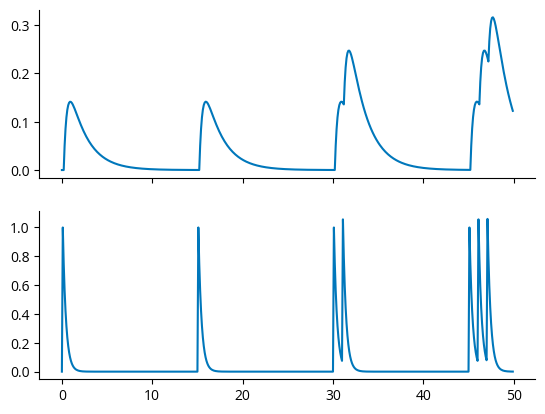

In [3]:
b2.prefs.codegen.target = "numpy"
ng = b2.NeuronGroup(
    1,
    """dv/dt = (I_syn - v)/ms : 1
    I_syn : 1""",
)
t_spk = [0, 15, 30, 31, 45, 46, 47] * b2.ms
sgg = b2.SpikeGeneratorGroup(
    1,
    np.zeros(len(t_spk)),
    t_spk,
)
tau_dsyn = 2 * b2.ms
tau_rsyn = 0.4 * b2.ms
syn = b2.Synapses(
    sgg,
    ng,
    """dI_syn_syn/dt = (s - I_syn)/tau_dsyn : 1
    I_syn_post = I_syn_syn : 1 (summed)
    ds/dt = -s/tau_rsyn : 1""",
    on_pre="s += 1",
)
syn.connect(i=0, j=0)
syn_mon = b2.StateMonitor(syn, ["I_syn", "s"], record=True)
net = b2.Network(ng, sgg, syn, syn_mon)
net.run(50 * b2.ms)
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(syn_mon.t / b2.ms, syn_mon.I_syn[0])
print(syn_mon.I_syn.max())

ax2.plot(syn_mon.t / b2.ms, syn_mon.s[0])

WARNING    The name "tau_dsyn" refers to different objects in different namespaces used for resolving names in the context of group "synapses". Will use the object from the group-specific namespace with the value 2. * msecond, but the name also refers to a variable in the run namespace with value '2. * msecond'. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    The name "tau_rsyn" refers to different objects in different namespaces used for resolving names in the context of group "synapses". Will use the object from the group-specific namespace with the value 0.4 * msecond, but the name also refers to a variable in the run namespace with value '0.4 * msecond'. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    The name "tau_dsyn" refers to different objects in different namespaces used for resolving names in the context of group "synapses_2". Will use the object from the group-specific namespace with the value 5. * msecond, but the name also refers to a

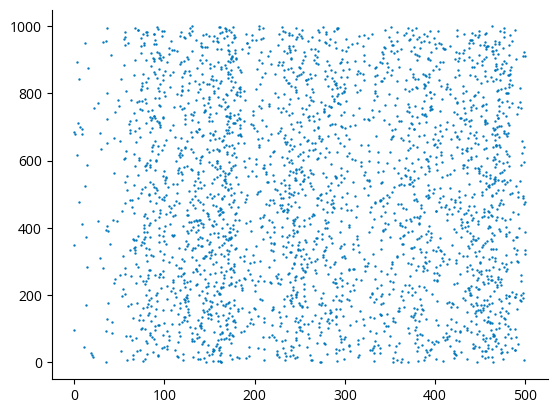

In [4]:
from random import sample

N_Excit = 800
N_Inhib = None  # None = N_Excit / 4
N_extern = 1000
connection_probability = 0.1
# w0 = 0.1 * b2.mV
w0 = 0.07 * b2.nA
g = 4
synaptic_delay = 1.5 * b2.ms
# poisson_input_rate = 13 * b2.Hz
poisson_input_rate = 9 * b2.Hz
# w_external = None
w_external = 0.1 * b2.mV
v_rest = -70 * b2.mV
v_reset = -60 * b2.mV
firing_threshold = -50 * b2.mV
membrane_time_scale = 20 * b2.ms
Rm = 100 * b2.Mohm
abs_refractory_period = 2 * b2.ms
monitored_subset_size = 1000
random_vm_init = True
"""
Fully parametrized implementation of a sparsely connected network of LIF neurons (Brunel 2000)

Args:
    N_Excit (int): Size of the excitatory popluation
    N_Inhib (int): optional. Size of the inhibitory population.
        If not set (=None), N_Inhib is set to N_excit/4.
    N_extern (int): optional. Number of presynaptic excitatory poisson neurons. Note: if set to a value,
        this number does NOT depend on N_Excit and NOT depend on connection_probability (this is different
        from the book and paper. Only if N_extern is set to 'None', then N_extern is computed as
        N_Excit*connection_probability.
    connection_probability (float): probability to connect to any of the (N_Excit+N_Inhib) neurons
        CE = connection_probability*N_Excit
        CI = connection_probability*N_Inhib
        Cexternal = N_extern
    w0 (float): Synaptic strength J
    g (float): relative importance of inhibition. J_exc = w0. J_inhib = -g*w0
    synaptic_delay (Quantity): Delay between presynaptic spike and postsynaptic increase of v_m
    poisson_input_rate (Quantity): Poisson rate of the external population
    w_external (float): optional. Synaptic weight of the excitatory external poisson neurons onto all
        neurons in the network. Default is None, in that case w_external is set to w0, which is the
        standard value in the book and in the paper Brunel2000.
        The purpose of this parameter is to see the effect of external input in the
        absence of network feedback(setting w0 to 0mV and w_external>0).
    v_rest (Quantity): Resting potential
    v_reset (Quantity): Reset potential
    firing_threshold (Quantity): Spike threshold
    membrane_time_scale (Quantity): tau_m
    abs_refractory_period (Quantity): absolute refractory period, tau_ref
    monitored_subset_size (int): nr of neurons for which a VoltageMonitor is recording Vm
    random_vm_init (bool): if true, the membrane voltage of each neuron is initialized with a
        random value drawn from Uniform(v_rest, firing_threshold)
    sim_time (Quantity): Simulation time

Returns:
    (rate_monitor, spike_monitor, voltage_monitor, idx_monitored_neurons)
    PopulationRateMonitor: Rate Monitor
    SpikeMonitor: SpikeMonitor for ALL (N_Excit+N_Inhib) neurons
    StateMonitor: membrane voltage for a selected subset of neurons
    list: index of monitored neurons. length = monitored_subset_size
"""
if N_Inhib is None:
    N_Inhib = int(N_Excit / 4)
if N_extern is None:
    N_extern = int(N_Excit * connection_probability)
if w_external is None:
    w_external = w0

J_excit = w0
J_inhib = -g * w0

lif_dynamics = """
    dv/dt = (-(v-v_rest) + Rm*(I_ampa + I_gaba)) / membrane_time_scale : volt (unless refractory)
    I_ampa : amp
    I_gaba : amp
"""

syn_eqs = """
    dI_syn_syn/dt = (s - I_syn)/tau_dsyn : amp
    I_syn_post = I_syn_syn : amp (summed)
    ds/dt = -s/tau_rsyn : amp
"""

neurons = b2.NeuronGroup(
    N_Excit + N_Inhib,
    model=lif_dynamics,
    threshold="v>firing_threshold",
    reset="v=v_reset",
    refractory=abs_refractory_period,
    method="linear",
)
if random_vm_init:
    neurons.v = (
        np.random.uniform(
            v_rest / b2.mV, high=firing_threshold / b2.mV, size=(N_Excit + N_Inhib)
        )
        * b2.mV
    )
else:
    neurons.v = v_rest
excitatory_population = neurons[:N_Excit]
inhibitory_population = neurons[N_Excit:]

exc_synapses = b2.Synapses(
    excitatory_population,
    target=neurons,
    model="""
        dI_syn_syn/dt = (s - I_syn_syn)/tau_dsyn : amp
        I_ampa_post = I_syn_syn : amp (summed)
        ds/dt = -s/tau_rsyn : amp
    """,
    on_pre="s += J_excit",
    delay=synaptic_delay,
    namespace={"tau_rsyn": 0.4 * b2.ms, "tau_dsyn": 2 * b2.ms},
)
exc_synapses.connect(p=connection_probability)

inhib_synapses = b2.Synapses(
    inhibitory_population,
    target=neurons,
    model="""
        dI_syn_syn/dt = (s - I_syn_syn)/tau_dsyn : amp
        I_gaba_post = I_syn_syn : amp (summed)
        ds/dt = -s/tau_rsyn : amp
    """,
    on_pre="s += J_inhib",
    delay=synaptic_delay,
    namespace={"tau_rsyn": 0.25 * b2.ms, "tau_dsyn": 5 * b2.ms},
)
inhib_synapses.connect(p=connection_probability)

external_poisson_input = b2.PoissonInput(
    target=neurons,
    target_var="v",
    N=N_extern,
    rate=poisson_input_rate,
    weight=w_external,
)

# collect data of a subset of neurons:
monitored_subset_size = min(monitored_subset_size, (N_Excit + N_Inhib))
idx_monitored_neurons = sample(range(N_Excit + N_Inhib), monitored_subset_size)
# rate_monitor = b2.PopulationRateMonitor(neurons)
spike_monitor = b2.SpikeMonitor(neurons, record=idx_monitored_neurons)
# voltage_monitor = b2.StateMonitor(neurons, "v", record=idx_monitored_neurons)
current_monitor = b2.StateMonitor(
    neurons, ["I_ampa", "I_gaba"], record=idx_monitored_neurons
)

net = b2.Network(
    neurons,
    exc_synapses,
    inhib_synapses,
    external_poisson_input,
    # rate_monitor,
    spike_monitor,
    # voltage_monitor,
    current_monitor,
)

net.run(0.5 * b2.second)

[Text(0.5, 0, 'time (ms)'), Text(0, 0.5, 'neuron index')]

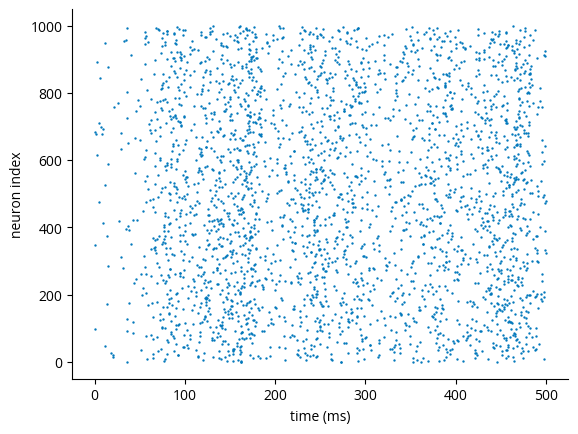

In [17]:
fig, ax = plt.subplots()
ax.scatter(spike_monitor.t / b2.ms, spike_monitor.i, s=0.5)
ax.set(xlabel="time (ms)", ylabel="neuron index")

Let's give our neurons coordinates in space and choose recording sites:

In [5]:
rng = np.random.default_rng()
neuron_coords = rng.uniform(-250, 250, (N_Excit + N_Inhib, 3))
neuron_coords[:5]

array([[  13.63637545,  -61.67890763,  249.05108712],
       [-210.57542008,  228.59435645,  246.45944813],
       [ 142.63916597,  131.76545919,  193.37815092],
       [ 177.38217872, -160.96564649,   37.89998081],
       [ 161.31734498, -198.6717685 ,   64.62401777]])

In [6]:
rec_radii = np.array([0, 250, 500])
elec_coords = np.meshgrid(rec_radii, [0], np.linspace(-400, 600, 10))
elec_coords = np.column_stack([a.flatten() for a in elec_coords])
elec_coords.shape

(30, 3)

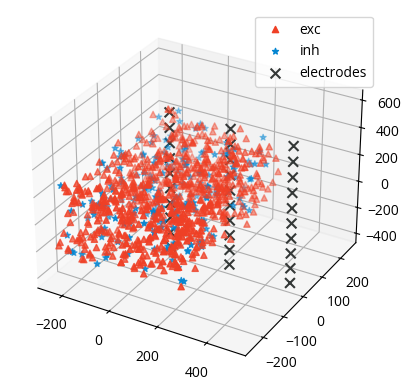

In [7]:
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.scatter(*neuron_coords[:N_Excit].T, marker="^", color="xkcd:tomato", label="exc")
ax.scatter(*neuron_coords[N_Excit:].T, marker="*", color="xkcd:cerulean", label="inh")
ax.scatter(
    *elec_coords.T, marker="x", alpha=1, s=50, color="xkcd:charcoal", label="electrodes"
)
ax.legend()

Now we initialize a `WSLFP` object which stores the contributions from each source to the total LFP.
We can either follow Mazzoni, Linden *et al.*'s original approach of aggregating currents over the whole population, or treat each neuron as its own source.
The `WSLFP` computes relative coordinates between electrodes and current sources and stores the amplitude contribution of each source to the total signal.
Different amplitude profiles are available:
- `mazzoni15`: derived from [Fig. 2B of the original paper](https://doi.org/10.1371/journal.pcbi.1004584.g002).
    The most accurate option since it was based on detailed simulations.
    It is most appropriate when each source represents a population of neurons since that is how the data was produced.
- `mazzoni15_single`: has the same shape as `mazzoni15`, but is optimally shrunk so that the profile of individual neurons averaged out over a 250 μm-radius cylinder produces the population profile.
- `aussel18`: uses the equation for contributions from individual neurons as described in [Aussel *et al.*, 2018](https://doi.org/10.1007/s10827-018-0704-x).

For a detailed comparison, see [`amplitude_comparison.ipynb`](./amplitude_comparison.ipynb).


In [8]:
import wslfp

wslfp_computer = wslfp.WSLFP.from_xyz_coords(
    elec_coords, neuron_coords, amp_func=wslfp.amplitude.aussel18
)
wslfp_computer_pop = wslfp.WSLFP.from_xyz_coords(
    elec_coords, [0, 0, 0], amp_func=wslfp.amplitude.mazzoni15
)

We then compute the LFP signal from the synaptic currents we recorded during the simulation.
For demonstration purposes, we use again use both the population and per-neuron versions:

In [9]:
t_ms = current_monitor.t / b2.ms
lfp = wslfp_computer.compute(
    t_ms, current_monitor.I_ampa.T, t_ms, current_monitor.I_gaba.T, t_ms
)

WARNING    /home/kyle/Dropbox (GaTech)/projects/wslfp/wslfp/__init__.py:130: UserWarning: Insufficient current data to interpolate for the requested times. Assuming 0 current for out-of-range times. Needed [-6.0, 493.9] ms, provided [0.0, 499.9] ms.
  warnings.warn(
 [py.warnings]


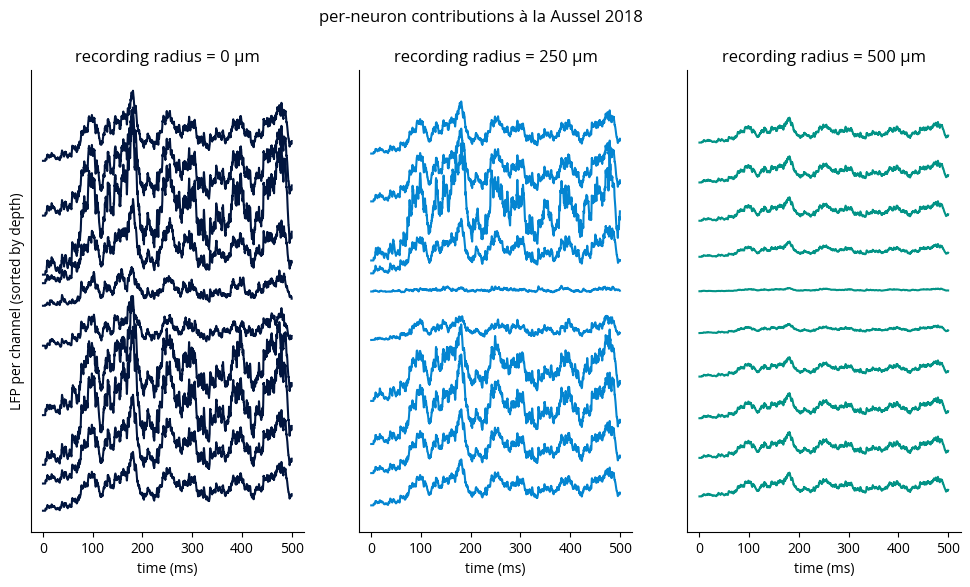

In [14]:
def plot_lfp(lfp, title=None):
    n_shanks = 3
    n_contacts_per_shank = 10
    fig, axs = plt.subplots(1, n_shanks, sharey=True, figsize=(12, 6))
    for i, color, r_rec, ax in zip(
        range(n_shanks), ["xkcd:navy", "xkcd:cerulean", "xkcd:teal"], rec_radii, axs
    ):
        lfp_for_shank = lfp[
            :, i * n_contacts_per_shank : (i + 1) * n_contacts_per_shank
        ]
        ax.plot(
            t_ms,
            lfp_for_shank + np.arange(n_contacts_per_shank) * np.quantile(lfp, 0.99),
            c=color,
        )
        ax.set(xlabel="time (ms)", yticks=[], title=f"recording radius = {r_rec} µm")

    axs[0].set(ylabel="LFP per channel (sorted by depth)")
    if title:
        fig.suptitle(title)


plot_lfp(lfp, "per-neuron contributions à la Aussel 2018")

WARNING    /home/kyle/Dropbox (GaTech)/projects/wslfp/wslfp/__init__.py:130: UserWarning: Insufficient current data to interpolate for the requested times. Assuming 0 current for out-of-range times. Needed [-6.0, 493.9] ms, provided [0.0, 499.9] ms.
  warnings.warn(
 [py.warnings]


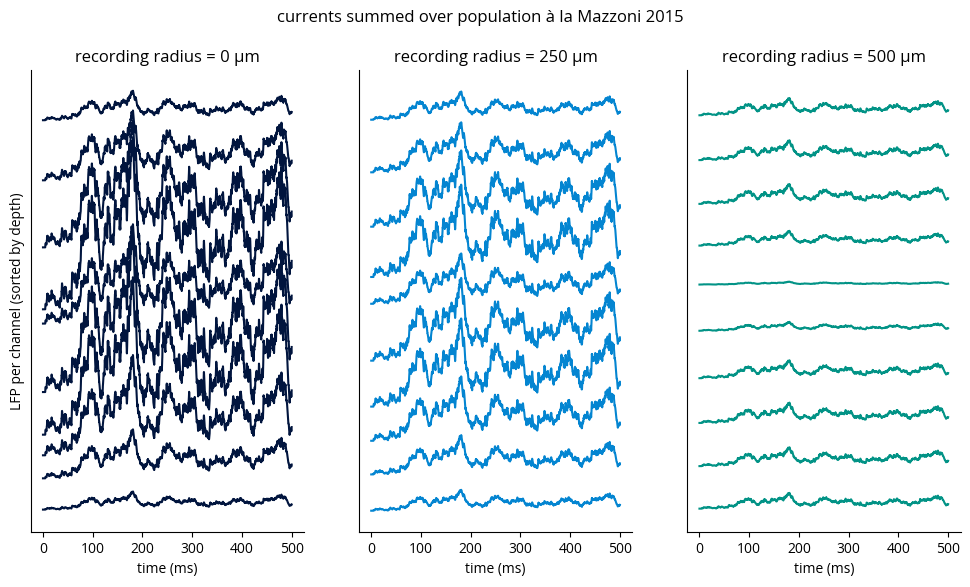

In [15]:
lfp_pop = wslfp_computer_pop.compute(
    t_ms,
    current_monitor.I_ampa.sum(axis=0),
    t_ms,
    current_monitor.I_gaba.sum(axis=0),
    t_ms,
)
plot_lfp(lfp_pop, title="currents summed over population à la Mazzoni 2015")